# Project 2: Topic Classification

Tim Spittle  
W207 - Applied Machine Learning  
Profossor: Alex Iliev  
Date: March 18, 2019

### Prompt 
In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
# DEPRECATED from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# ADDED for neater outputs
import pandas
import seaborn

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset = 'train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories = categories)
newsgroups_test = fetch_20newsgroups(subset = 'test',
                                     remove = ('headers', 'footers', 'quotes'),
                                     categories = categories)

In [4]:
num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target
target_names = newsgroups_train.target_names

print('training data length:', len(train_data))
print('training label shape:', train_labels.shape)

print('test data length:', len(test_data))
print('test label shape:', test_labels.shape)

print('dev data shape:', len(dev_data))
print('dev label shape:', dev_labels.shape)

print('labels names:', target_names)

training data length: 2034
training label shape: (2034,)
test data length: 677
test label shape: (677,)
dev data shape: 676
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## (Question 1) For each of the first 5 training examples, print the text of the message along with the label.

In [5]:
for ex in range(5):
    print('EXAMPLE: ' + str(ex) + ' / Label: ' + str(newsgroups_train.target_names[train_labels[ex]]))
    print(train_data[ex])
    print()    

EXAMPLE: 0 / Label: comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

EXAMPLE: 1 / Label: talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
fo

## (2) Use CountVectorizer to turn the raw training text into feature vectors.  
You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

In [6]:
vectorizer = CountVectorizer(analyzer = 'word') 
train_data_transform = vectorizer.fit_transform(train_data)

**a. The output of the transform (also of fit_transform) is a sparse matrix:** http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  
- What is the size of the vocabulary?  
- What is the average number of non-zero features per example? 
- What fraction of the entries in the matrix are non-zero?  
_Hint:_ use "nnz" and "shape" attributes.

In [7]:
print('The vocabulary consists of ' + str(train_data_transform.shape[1]) + ' words')
print('Of the ' + str((train_data_transform.shape[0] * train_data_transform.shape[1])) + ' entries in the matrix, ' + 
      str(round(train_data_transform.nnz / (train_data_transform.shape[0] * train_data_transform.shape[1]) * 100, 3)) + '% (' + 
      str(train_data_transform.nnz) + ') of them are non-zero.')
print('The avergae number of non-zero features per example is ' + 
      str(round(train_data_transform.nnz / train_data_transform.shape[0], 2)))

The vocabulary consists of 26879 words
Of the 54671886 entries in the matrix, 0.36% (196700) of them are non-zero.
The avergae number of non-zero features per example is 96.71


**b. What are the 0th and last feature strings (in alphabetical order)?**  
_Hint:_ use the vectorizer's `get_feature_names` function.

In [8]:
full_feature_list_train = vectorizer.get_feature_names()
print('0th feature string: ' + full_feature_list_train[0])
print('Last feature string: ' + full_feature_list_train[len(full_feature_list_train)-1])

0th feature string: 00
Last feature string: zyxel


**c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"].**  
Confirm the training vectors are appropriately shaped.  
Now what's the average number of non-zero features per example?

In [9]:
my_vocab = ['atheism', 'graphics', 'space', 'religion']
vectorizer_myvocab = CountVectorizer(vocabulary = my_vocab)
train_data_mv_transform = vectorizer_myvocab.fit_transform(train_data)
print('Confirm shape is appropriate: ' + 
      str(train_data_mv_transform.shape))
print('Of the ' + str((train_data_mv_transform.shape[0] * train_data_mv_transform.shape[1])) + ' entries in the matrix, ' + 
      str(round(train_data_mv_transform.nnz / (train_data_mv_transform.shape[0] * train_data_mv_transform.shape[1]) * 100, 3)) + '% (' + 
      str(train_data_mv_transform.nnz) + ') of them are non-zero.')
print('The avergae number of non-zero features per example (with 4-word vocabulary) is ' + 
      str(round(train_data_mv_transform.nnz / train_data_mv_transform.shape[0], 2)))

Confirm shape is appropriate: (2034, 4)
Of the 8136 entries in the matrix, 6.711% (546) of them are non-zero.
The avergae number of non-zero features per example (with 4-word vocabulary) is 0.27


**d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features.**  
What size vocabulary does this yield?

In [10]:
# Bigram & Trigram
vectorizer_ngram = CountVectorizer(ngram_range = (2,3), analyzer = 'char_wb')
train_data_ngram_transform = vectorizer_ngram.fit_transform(train_data)
print('The bigram/trigram vocabulary consists of ' + str(train_data_ngram_transform.shape[1]) + ' features')

The bigram/trigram vocabulary consists of 28954 features


**e. Use the "min_df" argument to prune words that appear in fewer than 10 documents.**  
What size vocabulary does this yield?

In [11]:
# Prune
vectorizer_prune = CountVectorizer(min_df = 10)
train_data_prune_transform = vectorizer_prune.fit_transform(train_data)
print('The pruned vocabulary consists of ' + str(train_data_prune_transform.shape[1]) + ' words')

The pruned vocabulary consists of 3064 words


**f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary?**  
_Hint:_ build a vocabulary for both train and dev and look at the size of the difference.  

In [12]:
vectorizer_dev = CountVectorizer()
dev_data_transform = vectorizer_dev.fit_transform(dev_data)

full_feature_list_dev = vectorizer_dev.get_feature_names()
print('Feature list length (train): ' + str(len(full_feature_list_train)))
print('Feature list length (dev): ' + str(len(full_feature_list_dev)))

features_dev_not_train = np.setdiff1d(full_feature_list_dev, full_feature_list_train)
print('Features in dev, not in train: ' + str(len(features_dev_not_train)) +
     ' (' + str(round(len(features_dev_not_train) / len(full_feature_list_dev) * 100, 2)) + '%)')

Feature list length (train): 26879
Feature list length (dev): 16246
Features in dev, not in train: 4027 (24.79%)


## (3) Use the default CountVectorizer options and: 
1. Report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier. Find the optimal value for k.
2. Fit a Multinomial Naive Bayes model and find the optimal value for alpha. 
3. Fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization.  

In [13]:
# Create vectorizer with training corpus vocabulary to transform and align dev data
vectorizer_dev_align = CountVectorizer(vocabulary = full_feature_list_train)
dev_data_align_transform = vectorizer_dev_align.fit_transform(dev_data)

# Check nuber of features is aligned
print(train_data_transform.shape)
print(dev_data_align_transform.shape)

(2034, 26879)
(676, 26879)


### KNN

In [14]:
# GridSearchCV over range of values of 'n_neighbors' to find optimal value
k_values = {'n_neighbors': list(range(1, 200))}
k_search = GridSearchCV(KNeighborsClassifier(), k_values, cv = 3, return_train_score = True)
k_search.fit(train_data_transform, train_labels)
pandas.DataFrame(k_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.004985,0.000001,0.102790,0.007131,1,{'n_neighbors': 1},0.430044,0.384389,0.412722,0.409046,0.018832,177,0.977122,0.979336,0.976436,0.977631,0.001237
1,0.005985,0.000815,0.101620,0.003391,2,{'n_neighbors': 2},0.425626,0.377025,0.406805,0.403147,0.020023,190,0.673063,0.764576,0.733432,0.723690,0.037990
2,0.005320,0.000472,0.098238,0.003664,3,{'n_neighbors': 3},0.406480,0.382916,0.397929,0.395772,0.009747,198,0.639852,0.662731,0.621502,0.641362,0.016865
3,0.004655,0.000471,0.105886,0.004721,4,{'n_neighbors': 4},0.430044,0.375552,0.393491,0.399705,0.022690,195,0.647970,0.670111,0.631811,0.649964,0.015699
4,0.004655,0.000471,0.101213,0.002037,5,{'n_neighbors': 5},0.444772,0.391753,0.390533,0.409046,0.025295,177,0.638376,0.642066,0.617820,0.632754,0.010667
5,0.005661,0.001254,0.108112,0.004882,6,{'n_neighbors': 6},0.450663,0.368189,0.392012,0.403638,0.034679,188,0.611070,0.627306,0.606038,0.614805,0.009075
6,0.004322,0.000470,0.108653,0.003584,7,{'n_neighbors': 7},0.437408,0.407953,0.378698,0.408063,0.023959,179,0.592620,0.595572,0.586156,0.591449,0.003932
7,0.007979,0.004231,0.120085,0.014575,8,{'n_neighbors': 8},0.432990,0.379971,0.371302,0.394789,0.027273,199,0.586716,0.605904,0.578792,0.590471,0.011382
8,0.005654,0.000944,0.135136,0.027168,9,{'n_neighbors': 9},0.431517,0.403535,0.396450,0.410521,0.015141,174,0.594096,0.592620,0.581001,0.589239,0.005856
9,0.005652,0.001695,0.115690,0.012322,10,{'n_neighbors': 10},0.440353,0.405007,0.394970,0.413471,0.019466,170,0.576384,0.580812,0.574374,0.577190,0.002689


In [15]:
print('K-Nearest Neighbors newsgroup classifier results')
print('Best K parameter: ' + str(k_search.best_params_['n_neighbors']))
knn = k_search.best_estimator_
knn.fit(train_data_transform, train_labels)
dev_pred_knn = knn.predict(dev_data_align_transform)
print(classification_report(dev_labels, dev_pred_knn))

K-Nearest Neighbors newsgroup classifier results
Best K parameter: 151
              precision    recall  f1-score   support

           0       0.46      0.32      0.37       165
           1       0.45      0.65      0.53       185
           2       0.47      0.54      0.50       199
           3       0.30      0.16      0.21       127

   micro avg       0.44      0.44      0.44       676
   macro avg       0.42      0.41      0.40       676
weighted avg       0.43      0.44      0.42       676



### Naive Bayes

In [16]:
# GridSearchCV over range of values of 'alpha' to find optimal value
alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
alpha_search = GridSearchCV(MultinomialNB(), alphas, cv = 3, return_train_score = True)
alpha_search.fit(train_data_transform, train_labels)
pandas.DataFrame(alpha_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.013297,0.002048,0.002660,4.690664e-04,0.0001,{'alpha': 0.0001},0.824742,0.818851,0.832840,0.825467,0.005732,3,0.963838,0.961624,0.966127,0.963863,0.001838
1,0.012634,0.001244,0.003324,4.717077e-04,0.001,{'alpha': 0.001},0.824742,0.821797,0.831361,0.825959,0.003997,2,0.963838,0.960886,0.965390,0.963371,0.001868
2,0.010307,0.000470,0.003324,9.411112e-04,0.01,{'alpha': 0.01},0.826215,0.821797,0.837278,0.828417,0.006507,1,0.962362,0.960148,0.963918,0.962142,0.001547
3,0.011635,0.000471,0.002327,4.700217e-04,0.1,{'alpha': 0.1},0.820324,0.805596,0.840237,0.822026,0.014188,4,0.957196,0.956458,0.958027,0.957227,0.000641
4,0.010306,0.001244,0.002328,4.693488e-04,0.5,{'alpha': 0.5},0.810015,0.790869,0.825444,0.808751,0.014138,5,0.940959,0.935055,0.939617,0.938544,0.002527
5,0.010982,0.001629,0.001653,4.640346e-04,1,{'alpha': 1.0},0.792342,0.774669,0.821006,0.795969,0.019084,6,0.927675,0.920295,0.932253,0.926741,0.004926
6,0.008646,0.000472,0.001993,8.991328e-07,2,{'alpha': 2.0},0.768778,0.754050,0.798817,0.773845,0.018618,7,0.898155,0.899631,0.912371,0.903386,0.006382
7,0.009642,0.000472,0.001994,8.145882e-04,10,{'alpha': 10.0},0.703976,0.692194,0.656805,0.684366,0.020032,8,0.755720,0.783026,0.733432,0.757392,0.020281


In [17]:
print('Multinomial Naive Bayes newsgroup classifier results')
print('Best alpha parameter: ' + str(alpha_search.best_params_['alpha']))
mnb = alpha_search.best_estimator_
mnb.fit(train_data_transform, train_labels)
dev_pred_mnb = mnb.predict(dev_data_align_transform)
print(classification_report(dev_labels, dev_pred_mnb))

Multinomial Naive Bayes newsgroup classifier results
Best alpha parameter: 0.01
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       165
           1       0.92      0.90      0.91       185
           2       0.81      0.89      0.85       199
           3       0.65      0.50      0.57       127

   micro avg       0.78      0.78      0.78       676
   macro avg       0.76      0.75      0.76       676
weighted avg       0.78      0.78      0.78       676



### Logistic

In [18]:
# GridSearchCV over range of values of 'C' to find optimal value
cs = {'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]}
logitreg = LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 1000, multi_class = 'auto')
c_search = GridSearchCV(logitreg, cs, cv = 3, return_train_score = True)
c_search.fit(train_data_transform, train_labels)
pandas.DataFrame(c_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.507309,0.347066,0.003325,0.001245,0.01,{'C': 0.01},0.727541,0.717231,0.733728,0.726155,0.006803,9,0.870849,0.872325,0.879234,0.874136,0.003655
1,3.175180,0.176297,0.003658,0.001696,0.1,{'C': 0.1},0.759941,0.751105,0.760355,0.757129,0.004268,1,0.971956,0.968266,0.968336,0.969519,0.001723
2,3.703993,0.740437,0.002991,0.000001,0.25,{'C': 0.25},0.762887,0.754050,0.754438,0.757129,0.004079,1,0.977860,0.977122,0.977172,0.977385,0.000337
3,3.781733,0.264076,0.003656,0.001694,0.5,{'C': 0.5},0.758468,0.743741,0.752959,0.751721,0.006080,3,0.978598,0.979336,0.977172,0.978369,0.000898
4,4.048513,0.459353,0.002659,0.000470,0.75,{'C': 0.75},0.756996,0.742268,0.748521,0.749263,0.006040,4,0.979336,0.979336,0.977909,0.978860,0.000673
5,4.974040,0.705294,0.007978,0.007052,1,{'C': 1.0},0.752577,0.740795,0.745562,0.746313,0.004843,5,0.979336,0.979336,0.977909,0.978860,0.000673
6,4.695948,0.391290,0.002659,0.000470,2,{'C': 2.0},0.745214,0.740795,0.744083,0.743363,0.001875,7,0.979336,0.979336,0.977909,0.978860,0.000673
7,4.793837,0.153906,0.002993,0.000815,5,{'C': 5.0},0.746686,0.742268,0.742604,0.743854,0.002009,6,0.979336,0.979336,0.977909,0.978860,0.000673
8,6.434534,0.721659,0.002659,0.000470,10,{'C': 10.0},0.739323,0.742268,0.738166,0.739921,0.001727,8,0.980074,0.979336,0.977909,0.979106,0.000899


In [19]:
print('Logistic Regression newsgroup classifier results')
print('Best C parameter: ' + str(c_search.best_params_['C']))
logitreg_best = c_search.best_estimator_
logitreg_best.fit(train_data_transform, train_labels)
dev_pred_logitreg = logitreg_best.predict(dev_data_align_transform)
print(classification_report(dev_labels, dev_pred_logitreg))

Logistic Regression newsgroup classifier results
Best C parameter: 0.1
              precision    recall  f1-score   support

           0       0.61      0.56      0.58       165
           1       0.79      0.86      0.83       185
           2       0.74      0.82      0.78       199
           3       0.59      0.48      0.53       127

   micro avg       0.70      0.70      0.70       676
   macro avg       0.68      0.68      0.68       676
weighted avg       0.69      0.70      0.70       676



A few questions:

a. Why doesn't nearest neighbors work well for this problem?
- KNN likely does not work well for this problem because the words in the bag-of-words are not weighted. As such, two posts may share many words but if a few **key** words are different they will still be close neighbors despite clearly being in different topics given those more meaningful keyword differences. This coincidental overlap likely results from such a large feature space where many general words may be used in many posts and all weighted the same in KNN.  

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?  
- Logistic regression likely doesn't work as well as Naive Bayes because of the way the weights/coefficients are applied. In logistic regression, coefficients identify weights of features given all other features are equal. This may overfit the model, as some **key** words likely dictate the topic much more than others. Naive Bayes applies a simple weight to each word and therefore takes those key words into account with more weight regardless of the surrounding context. 

c. Logistic regression estimates a weight vector for each class, which you can access with the `coef\_` attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.  
- _See Below_ 
- The relationship between the sum and the value of C is positively correlated with a decay. 

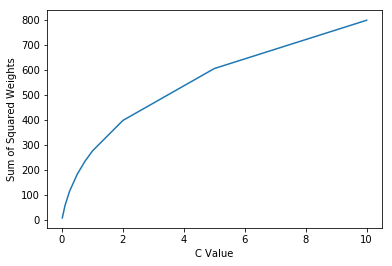

In [20]:
# Loop through all tested C values and capture sum of coefficients squared for each feature
c_weight_dict = {}
for c_in in cs['C']:
    # Fit logistic regression with loop value of 'C'
    logistic_loop = LogisticRegression(penalty = 'l2', C = c_in, solver = 'lbfgs', max_iter = 1000, multi_class = 'auto')
    logistic_loop.fit(train_data_transform, train_labels)
    
    # Loop through each feature, cumulatively adding sum of squared coefficients for each
    sum_square_feat_weight = 0
    for feat in range(logistic_loop.coef_.shape[0]):
        sum_square_feat_weight += sum(logistic_loop.coef_[feat,]**2)
    c_weight_dict[c_in] = sum_square_feat_weight
    
# Plot
plt.plot(c_weight_dict.keys(), c_weight_dict.values())
plt.xlabel('C Value')
plt.ylabel('Sum of Squared Weights')
plt.show()

## (4) Train a logistic regression model.  
Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels.  

In [21]:
def top_features_by_label(coef_matrix_in, target_names_in, feature_list_in):
    top_index_lists = []
    top_features_lists = []
    
    # Loop through each label in the coefficient matrix and identify the top 5 features
    for loop_labels in range(coef_matrix_in.shape[0]):
        top_5_index = np.argsort(coef_matrix_in[loop_labels])[::-1][:5]
        top_5_features = [feature_list_in[i] for i in top_5_index]

        top_index_lists.append(top_5_index)
        top_features_lists.append(top_5_features)

    # Flatten feature lists 
    full_top_index_list = [item for sublist in top_index_lists for item in sublist]
    full_top_features_list = [item for sublist in top_features_lists for item in sublist]

    # Creat 20x4 labelled table from coefficeint matrix
    top_20_index = pandas.DataFrame(data = coef_matrix_in[:,full_top_index_list].transpose(), \
                                    columns = target_names_in, index = full_top_features_list)

    # Plot resulting table
    fig, ax = plt.subplots(figsize = (10,10))
    seaborn.heatmap(top_20_index, annot = True)

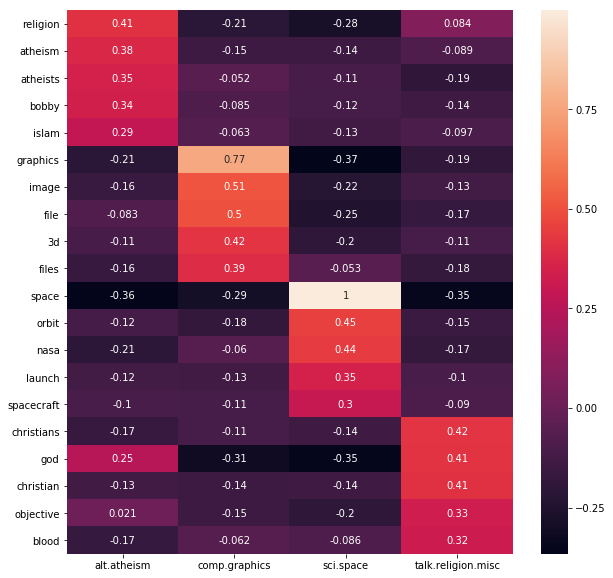

In [22]:
top_features_by_label(coef_matrix_in = logitreg_best.coef_, 
                      target_names_in = target_names, 
                      feature_list_in = full_feature_list_train)

ANSWER: 
- **alt.atheism:** "Atheism"/"atheists" are logically near the top of the features by weight, but it is interesting that "religion" is talked about more than atheism (as well as the prevalence of "Islam" on its own), especially given the fact that religion is a topic also analyzed within this model. "Bobby" must be someone on the message board that is talked about a lot, or else it could be slang/shorthand for something else.
- **comp.graphics:** Generally no surprises here, with "graphics", "image", and "3d" at or near the top. "File" and "files" is a bit more generic and may have less weight if we were also analyzing topics that may relate to files in some way. Additionally, it seems like these two words should be simplified to one with stemming in preprocessing.
- **sci.space:** "Space" in the topic about space being the highest weight among all weights is great, and the remaining terms are all quite relevant to space: "orbit", "NASA", "launch", and "spacecraft."
- **talk.religion.misc:** It would appear that the religion talk, misc. newsgroup is very christian-friendly given the high scores for "christians" and "christian" (again, stemming would help here). "God" is rightfully high on the list, though "objective" is a rather general word. "Blood" being as high as it is is interesting; one could assume it has to do with "blood of christ" or something related to blood as mentioned in scripture. 

Create the table again with bigram features. Any surprising features in this table?

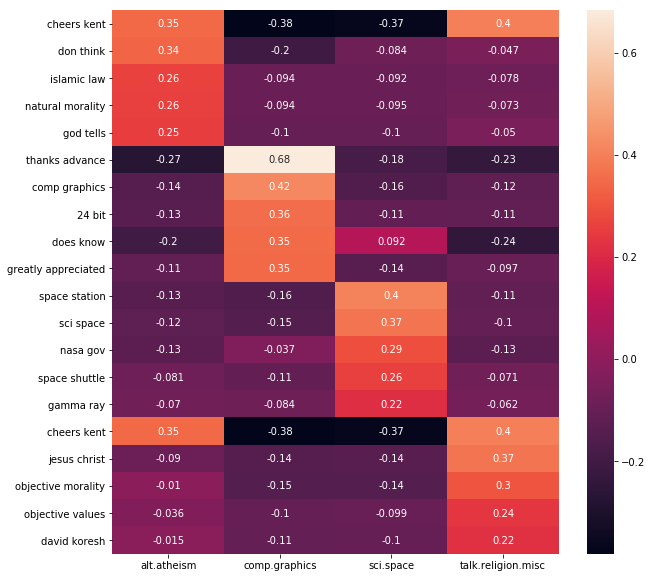

In [23]:
# Transform to use Bigram Words
vectorizer_ngram_word = CountVectorizer(ngram_range = (2,2), analyzer = 'word', stop_words = 'english')
train_data_ngram_word_transform = vectorizer_ngram_word.fit_transform(train_data)

# Train Logistic Regression
logitreg_bigram = c_search.best_estimator_
logitreg_bigram.fit(train_data_ngram_word_transform, train_labels)

# Top Features
top_features_by_label(coef_matrix_in = logitreg_bigram.coef_, 
                      target_names_in = target_names, 
                      feature_list_in = vectorizer_ngram_word.get_feature_names())

ANSWER:  
_NOTE:_ I removed stop words, as the results given raw bigram word features were quite general and not distinct to the topics.  
- **alt.atheism:** It is very interesting that "cheers kent" is so high on the list for both atheism and religion newsgroups. Given that it appears to be a sign-off from someone named Kent, he may be an avid poster in both message boards. "Don think" is a challenging feature, as it appears to be gramatically incorrect unless the stop_words parameter strips contractions. "Islamic law" and "god tells" are interesting results, as one would assume they may just as likely be terms used in religion messages boards but the weights show they are much more common in atheist message board. The most obvious term for atheism is "natural morality" which one can assume is a common refrain for people discussing morality without religion.
- **comp.graphics:** No surprise that the title of the newsgroup "comp graphics" is highly weighted along with a computer term such as "24 bit." However, the other terms "thanks (in) advance" and "greatly appreciated" seem to indicate that the people posting on the comp.graphics newsgroup are just far more likely to use such polite turns of phrase.
- **sci.space:** All highly weighted features here are very clearly related to space.
- **talk.religion.misc:** (See above comment on "cheers kent") Aside from the (again) christian-friendly mention of "Jesus Christ", there is substantial discussion of "objective morality" and "objective values", which seems logical given the teachings of relgion as it relates to morality. It is interesting that there is also so much talk of "David Koresh". 

## (5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer.  
The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization.  
For example, try: 
- Lowercasing everything
- Replacing sequences of numbers with a single token
- Removing various other non-letter characters
- Shortening long words  

If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and `re.sub()` in particular.  

With your new preprocessor, how much did you reduce the size of the dictionary?  
For reference, I was able to improve dev F1 by 2 points.

In [24]:
# Define pre-processor
def better_preprocessor(s):
    # Remove non-alphanumeric characters
    words_only = re.sub('\W|\_', ' ', s) # NOTE: underscores not included with 'W' special character
    # Replace multiple spaces with single spaces
    single_space = re.sub('\s+', ' ', words_only)
    # Replace numbers with token "numeros"
    number_tokens = re.sub('[0-9]+', 'numeros', single_space)
    # Lowercase
    all_lower = number_tokens.lower()
    #NOTE: re: shortening long words - no packages loaded can implement stemming
        # neither manually stemming nor arbitrarily shortening long words seemed appropriate

    return all_lower

# Use pre-processor and stop-words to vectorize training data
vectorizer_preprocessor = CountVectorizer(preprocessor = better_preprocessor, analyzer = 'word', stop_words = 'english')
train_data_pp_transform = vectorizer_preprocessor.fit_transform(train_data)

# Compare vocabulary
print('The original vocabulary consists of ' + str(train_data_transform.shape[1]) + ' words')
print('The pre-processed vocabulary consists of ' + str(train_data_pp_transform.shape[1]) + ' words ' + \
     str(train_data_transform.shape[1] - train_data_pp_transform.shape[1]) + ' less than the original.')

The original vocabulary consists of 26879 words
The pre-processed vocabulary consists of 24035 words 2844 less than the original.


In [25]:
# Train Logistic regression model with pre-processed training data
logitreg_2 = LogisticRegression(penalty = 'l2', solver = 'lbfgs', max_iter = 1000, multi_class = 'auto', C = 0.1)
logitreg_2.fit(train_data_pp_transform, train_labels)

# Trim dev corpus to align with newly trimmed train vocabulary
pp_feature_list = vectorizer_preprocessor.get_feature_names()
vectorizer_dev_align_pp = CountVectorizer(vocabulary = pp_feature_list)
dev_data_align_pp_transform = vectorizer_dev_align_pp.fit_transform(dev_data)

# Predict dev data
dev_pred_logitreg_2 = logitreg_2.predict(dev_data_align_pp_transform)
print(classification_report(dev_labels, dev_pred_logitreg_2))

              precision    recall  f1-score   support

           0       0.61      0.56      0.58       165
           1       0.87      0.85      0.86       185
           2       0.73      0.87      0.79       199
           3       0.64      0.52      0.57       127

   micro avg       0.72      0.72      0.72       676
   macro avg       0.71      0.70      0.70       676
weighted avg       0.72      0.72      0.72       676



**ANSWER:** I was able to improve the logistic regression f1 score by 2 points (from 70 to 72) by implementing a custom pre-processor.  

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

## (6) Train a logistic regression model using a "l1" penalty.  
Output the number of learned weights that are not equal to zero.  
- How does this compare to the number of non-zero weights you get with "l2"?  

In [26]:
# Train Logistic regression model with l1 penalty (first finding ideal C parameter given l1 penalty)
cs = {'C': [0.01, 0.1, 1.0, 2.0, 10.0, 20.0, 50.0, 100.0]}
logitreg_l1 = LogisticRegression(penalty = 'l1', solver = 'saga', multi_class = 'auto', tol = .01)
c_search_l1 = GridSearchCV(logitreg_l1, cs, cv = 3, return_train_score = True)
c_search_l1.fit(train_data_pp_transform, train_labels)
pandas.DataFrame(c_search_l1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.601065,0.025666,0.000667,0.000472,0.01,{'C': 0.01},0.477172,0.460972,0.365385,0.434612,0.049289,8,0.492251,0.464207,0.355670,0.437376,0.058898
1,1.196446,0.118781,0.002672,0.002405,0.1,{'C': 0.1},0.628866,0.606775,0.670118,0.635202,0.026237,7,0.645018,0.652399,0.670839,0.656085,0.010859
2,8.954749,1.537064,0.001316,0.000477,1,{'C': 1.0},0.678940,0.646539,0.717456,0.680924,0.028975,6,0.715129,0.711439,0.773196,0.733255,0.028283
3,12.998912,0.627442,0.000344,0.000487,2,{'C': 2.0},0.684831,0.653903,0.715976,0.684857,0.025332,5,0.722509,0.723985,0.782032,0.742842,0.027718
4,19.898565,1.298322,0.000000,0.000000,10,{'C': 10.0},0.693667,0.658321,0.713018,0.688299,0.022643,2,0.733579,0.732103,0.789396,0.751693,0.026667
5,20.591584,0.727275,0.000000,0.000000,20,{'C': 20.0},0.699558,0.655376,0.718935,0.691249,0.026597,1,0.735055,0.732103,0.793814,0.753658,0.028421
6,20.904644,1.272144,0.005539,0.007141,50,{'C': 50.0},0.693667,0.655376,0.715976,0.688299,0.025021,2,0.734317,0.734317,0.793814,0.754150,0.028047
7,21.455785,2.016351,0.000000,0.000000,100,{'C': 100.0},0.695140,0.655376,0.714497,0.688299,0.024608,2,0.735055,0.732841,0.791605,0.753167,0.027195


In [27]:
print('Best C parameter: ' + str(c_search_l1.best_params_['C']))
logitreg_l1_best = c_search_l1.best_estimator_
logitreg_l1_best.fit(train_data_pp_transform, train_labels)

print('Total count of weights (l1): ' + str(logitreg_l1_best.coef_.shape[0] * logitreg_l1_best.coef_.shape[1]))
print('Total count of non-zero weights (l1): ' + str(np.count_nonzero(logitreg_l1_best.coef_)))
print('Total count of weights (l2): ' + str(logitreg_2.coef_.shape[0] * logitreg_2.coef_.shape[1]))
print('Total count of non-zero weights (l2): ' + str(np.count_nonzero(logitreg_2.coef_)))

Best C parameter: 20.0
Total count of weights (l1): 96140
Total count of non-zero weights (l1): 85129
Total count of weights (l2): 96140
Total count of non-zero weights (l2): 96140


Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.  

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting `tol=.01` (the default is .0001).

In [28]:
# Loop through all tested C values
c_accuracy_dict = {}
for c_in in cs['C']:
    # Fit l1 logistic regression
    logistic_loop_l1 = LogisticRegression(penalty = 'l1', solver = 'saga', multi_class = 'auto', tol = .01, C = c_in)
    logistic_loop_l1.fit(train_data_pp_transform, train_labels)
    
    # Loop through each feature and identify those w/ any non-zero weights
    nonzero_index_list_l1 = []
    nonzero_features_list_l1 = []
    for loop_labels in range(logistic_loop_l1.coef_.shape[1]):
        nonzero_count = np.count_nonzero(logistic_loop_l1.coef_[:,loop_labels])
        if nonzero_count > 0:
            nonzero_index_list_l1.append(loop_labels)
            nonzero_features_list_l1.append(pp_feature_list[loop_labels])

    # Create vectorizer with the non-zero weight features vocabulary
    vectorizer_nonzerovocab_l1 = CountVectorizer(vocabulary = nonzero_features_list_l1)
    train_data_nonzero_transform_l1 = vectorizer_nonzerovocab_l1.fit_transform(train_data)
    dev_data_align_nonzero_transform_l1 = vectorizer_nonzerovocab_l1.fit_transform(dev_data)
    
    # Fit l2 logistic regression with l1 limited vocabulary
    logistic_loop_l2 = LogisticRegression(penalty = 'l2', C = 0.1, solver = 'lbfgs', max_iter = 1000, multi_class = 'auto')
    logistic_loop_l2.fit(train_data_nonzero_transform_l1, train_labels)

    # Add 'accuracy' to 'vocab size' index of dictionary
    c_accuracy_dict[len(nonzero_features_list_l1)] = logistic_loop_l2.score(dev_data_align_nonzero_transform_l1, dev_labels)

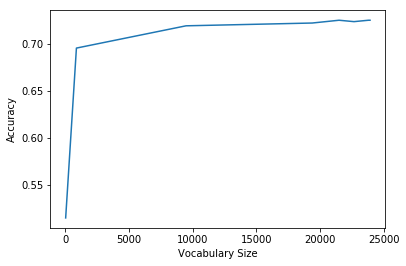

In [29]:
# Plot
plt.plot(c_accuracy_dict.keys(), c_accuracy_dict.values())
plt.xlabel('Vocabulary Size')
plt.ylabel('Accuracy')
plt.show()

## (7) Use the TfidfVectorizer (_NOTE: how is this different from the CountVectorizer?_) Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

`maximum predicted probability / predicted probability of the correct label`

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

**ANSWER:** Tf-idf stands for "term-frequency times inverse document-frequency" and it is a weighting scheme by which the impact of tokens are scaled down according to how frequently they are included in a given corpus. i.e. more common words are less informative than features that occur in a small fraction of the training corpus and should therefore be weighted accordingly.

In [30]:
# Use tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english")
train_data_tfidf_transform = tfidf_vectorizer.fit_transform(train_data)

# Trim dev corpus to align with tfidf train vocabulary
tfidf_feature_list = tfidf_vectorizer.get_feature_names()
vectorizer_dev_align_tfidf = TfidfVectorizer(analyzer = "word", stop_words = "english", vocabulary = tfidf_feature_list)
dev_data_align_tfidf_transform = vectorizer_dev_align_tfidf.fit_transform(dev_data)

# Train Logistic regression model
logitreg_tfidf = LogisticRegression(penalty = "l2", solver = "lbfgs", multi_class = "auto", \
                                    C = 100, max_iter = 10000, tol = 0.01)
logitreg_tfidf.fit(train_data_tfidf_transform, train_labels)

# Predict dev data
dev_pred_logitreg_tfidf = logitreg_tfidf.predict(dev_data_align_tfidf_transform)
dev_pred_proba_logitreg_tfidf = logitreg_tfidf.predict_proba(dev_data_align_tfidf_transform)
print(classification_report(dev_labels, dev_pred_logitreg_tfidf))

              precision    recall  f1-score   support

           0       0.70      0.61      0.65       165
           1       0.89      0.91      0.90       185
           2       0.79      0.88      0.83       199
           3       0.67      0.64      0.65       127

   micro avg       0.78      0.78      0.78       676
   macro avg       0.76      0.76      0.76       676
weighted avg       0.77      0.78      0.77       676



In [40]:
# Extract maximum predicted probability
max_prob = np.amax(dev_pred_proba_logitreg_tfidf, 1)
max_idx = np.argmax(dev_pred_proba_logitreg_tfidf, 1)

# Extract predicted probability of correct label
correct_prob = dev_pred_proba_logitreg_tfidf[range(dev_pred_proba_logitreg_tfidf.shape[0]), dev_labels]

# Calculate R
R = np.divide(max_prob, correct_prob)

# Print top 3 highest R
top_3_wrong_idx = R.argsort()[-3:][::-1]
for wrong in top_3_wrong_idx:
    print('R: ' + str(R[wrong]))
    print('Message:')
    print(dev_data[wrong])
    print('Correct label: ' + str(target_names[dev_labels[wrong]]))
    print('Predicted label: ' + str(target_names[max_idx[wrong]]))
    print()

R: 1285.926533368673
Message:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in the book itself
fo

**ANSWER:**  
- The most common type of mistake seems to be caused by the fact that certain topic overlap is always going to happen 
    - People talking about the Book of Mormon, for example, may be talking about the religious text, an FTP protocol to actually download the book, atheism as it relates to Mormonism, books in general, the musical, etc.
- One way to try to combat this topic overlap would be to try to identify the use of certain topics in context. This could include methods to: 
    - Replace proper nouns or quoted text with tokens so the context of what someone is talking about is weighted more heavily than the item itself
    - Sentiment analysis to decipher if someone is talking about an item positively or negatively
- In addition to the issue of context, some messages have flaws that make them more difficult to decipher in general. For example, some messages:
    - are too short to get much context 
    - contain acronyms that distort the bag of words
    - contain signatures, headers, or footers, that introduce text unrelated to the message itself
- Data cleaning steps could be taken to process these issues to the extent possible.